# LOAD PACKAGES

In [1]:
from bisect import bisect_left
import sys
sys.path.append(r"C:\Users\jarra\Desktop\Masters\Heatwave_Project")
import pandas as pd
import PT13_Functions_For_Masters_New_Test as HW_Func
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

# Data Involved

In [20]:
P_Gardens = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\perthgardens_daily_1880-1900.csv")
P_Gardens_Corr = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\perthgardens_daily_corrected_1880-1900.csv")

#Now we need to go back in time and minus 200 years off the date
#Convert To Datetime

P_Gardens['time'] = pd.to_datetime(P_Gardens['time'],format="%d/%m/%Y")
P_Gardens_Corr['time'] = pd.to_datetime(P_Gardens_Corr['time'],format="%d/%m/%Y")

#Split the Year up

P_Gardens = HW_Func.Date_Splitter(P_Gardens,'time',single= True)
P_Gardens_Corr = HW_Func.Date_Splitter(P_Gardens_Corr,'time',single= True)
P_Gardens['year'] = P_Gardens['year']-200
P_Gardens_Corr['year'] = P_Gardens_Corr['year']-200
#Combine in same format as ACORN-SAT

cols=["year","month","day"]
P_Gardens['date'] = P_Gardens[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
P_Gardens_Corr['date'] = P_Gardens_Corr[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

del P_Gardens['time']
del P_Gardens_Corr['time']
del P_Gardens['year']
del P_Gardens_Corr['year']
del P_Gardens['month']
del P_Gardens_Corr['month']
del P_Gardens['day']
del P_Gardens_Corr['day']

P_Gardens['date'] = pd.to_datetime(P_Gardens['date'],format="%Y/%m/%d")
P_Gardens_Corr['date'] = pd.to_datetime(P_Gardens_Corr['date'],format="%Y/%m/%d")

#Max Temp, (drop(0) has dropped the 0th index, so it starts at 1)
MaxT_Perth = pd.read_csv(r"C:\Users\jarra\Desktop\UPDATED TMAX, TMIN ACORN-SAT\tmax.009021.daily (3).csv").drop(0)
#Min Temp
MinT_Perth = pd.read_csv(r"C:\Users\jarra\Desktop\UPDATED TMAX, TMIN ACORN-SAT\tmin.009021.daily (2).csv").drop(0)
#Ave Temp
AvgT_Perth = (MaxT_Perth['maximum temperature (degC)']+MinT_Perth['minimum temperature (degC)'])/2

Maximum = pd.Series(MaxT_Perth['maximum temperature (degC)'], name="Max")
Minimum = pd.Series(MinT_Perth['minimum temperature (degC)'],name="Min")
Average = pd.Series(AvgT_Perth,name="Avg")

#The Daily Max Min Ave Data
ACORN_SAT = pd.concat([MaxT_Perth['date'],Maximum,Minimum,Average],axis=1)
ACORN_SAT['date'] = pd.to_datetime(ACORN_SAT['date'],format="%Y/%m/%d")



#Now load in and fix Perth Gardens 1830-1875
Per_Gard = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\swanriver_subdaily_1830-1875.csv")
Per_Gard
#Set Datetime
Per_Gard['date'] = pd.to_datetime(Per_Gard['date'],dayfirst = True)
    

#So this works, now we need to expand this into a for loop and make this a new dataframe to be added onto
#the historical time because it will make things easier



#Can't set index yet.
#Perth Regional Office 1967 to 1992 sub daily dataset
PRO_Sub = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\perthregionaloffice_subdaily_1942-1992.csv")

PRO_Sub['date'] = pd.to_datetime(PRO_Sub['date'],dayfirst = True)
PRO_Sub = PRO_Sub.set_index('date')
PRO_Sub =PRO_Sub['temp']/10 

PRO_Sub_ES  = PRO_Sub.loc['1967':'1992']
PRO_Sub_ES =PRO_Sub_ES

## Perth Regional Office Daily Extreme Dataset
#Load PRO in
#BOM PERTH REGIONAL OFFICE
MaxT_PRO = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\IDCJAC0010_009034_1800_Data.csv")
MinT_PRO = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\IDCJAC0011_009034_1800_Data.csv")

#Clean The data
MaxT_PRO['Datetime']= pd.to_datetime(MaxT_PRO[['Year', 'Month', 'Day']])
MinT_PRO['Datetime']= pd.to_datetime(MinT_PRO[['Year', 'Month', 'Day']])

#Delete irrelevent columns
del MaxT_PRO['Product code']
del MaxT_PRO['Bureau of Meteorology station number']
del MaxT_PRO['Year']
del MaxT_PRO['Month']
del MaxT_PRO['Day']
del MaxT_PRO['Days of accumulation of maximum temperature']
del MaxT_PRO['Quality']
del MinT_PRO['Product code']
del MinT_PRO['Bureau of Meteorology station number']
del MinT_PRO['Year']
del MinT_PRO['Month']
del MinT_PRO['Day']
del MinT_PRO['Days of accumulation of minimum temperature']
del MinT_PRO['Quality']

#Change the column name to date
MaxT_PRO= MaxT_PRO.rename(columns={'Datetime':'date'})
MinT_PRO= MinT_PRO.rename(columns={'Datetime':'date'})


#Change the column names
MaxT_PRO= MaxT_PRO.rename(columns={'Maximum temperature (Degree C)':'PRO Max'})
MinT_PRO= MinT_PRO.rename(columns={'Minimum temperature (Degree C)':'PRO Min'})

#Now concat it
MaxT_PRO= MaxT_PRO.set_index('date')
MinT_PRO= MinT_PRO.set_index('date')

PRO_DE = pd.merge(left = MaxT_PRO,right  =MinT_PRO,left_index=True,right_index=True  )



In [21]:
#Training Data
PRO_DE_Training = PRO_DE.loc['1967':'1992']
PRO_Sub_Training = PRO_Sub_ES

In [22]:
#Estimating Data
PRO_Sub_4_Est = PRO_Sub.reset_index()
Per_Gard

,date,temp
0,1830-04-16 12:00:00,23.1
1,1830-04-16 15:00:00,25.8
2,1830-04-17 10:00:00,22.2
3,1830-04-17 15:00:00,26.4
4,1830-04-18 10:00:00,23.3
...,...,...
26388,1875-12-29 16:00:00,33.9
26389,1875-12-30 10:00:00,25.6
26390,1875-12-30 16:00:00,31.1
26391,1875-12-31 10:00:00,25.0


# Applying The Function

In [23]:
A2,B2,C2,D2,E2,F2,G2,H2,I2,J2,K2,L2, M2, N2,O2 ,P2, Q2, R2, S2, T2, U2= Temperature_Extreme_Estimiation_Function(PRO_Sub_Training,PRO_DE_Training,PRO_Sub_4_Est, 1, False)


In [216]:
A,B,C,D,E,F,G,H,I,J,K,L, M, N,O ,P, Q, R, S, T, U= Temperature_Extreme_Estimiation_Function(PRO_Sub_Training,PRO_DE_Training,Per_Gard, 1, False)


# Plotting the Results

In [218]:
#Plot T
#1830-1875 resample
HIST_1 = T.get('Trial_1').set_index('Date').resample('Y').mean().reset_index()

#1942-1992 resample
PRO_1 = T2.get('Trial_1').set_index('Date').resample('Y').mean().reset_index()


#PRO DE
PRO_DE_Y = PRO_DE.resample('Y').mean().reset_index()

#ACORN_SAT
ACORN_SAT_Y = ACORN_SAT.set_index('date').resample('Y').mean().reset_index()

#P_Gardens|
P_Gardens_Y =  P_Gardens.set_index('date').resample('Y').mean().reset_index()

P_Gardens_CORR_Y = P_Gardens_Corr.set_index('date').resample('Y').mean().reset_index()

Text(0.5, 1.0, 'Average Yearly Maximum Temperature With All Avaliable Information For Perth')

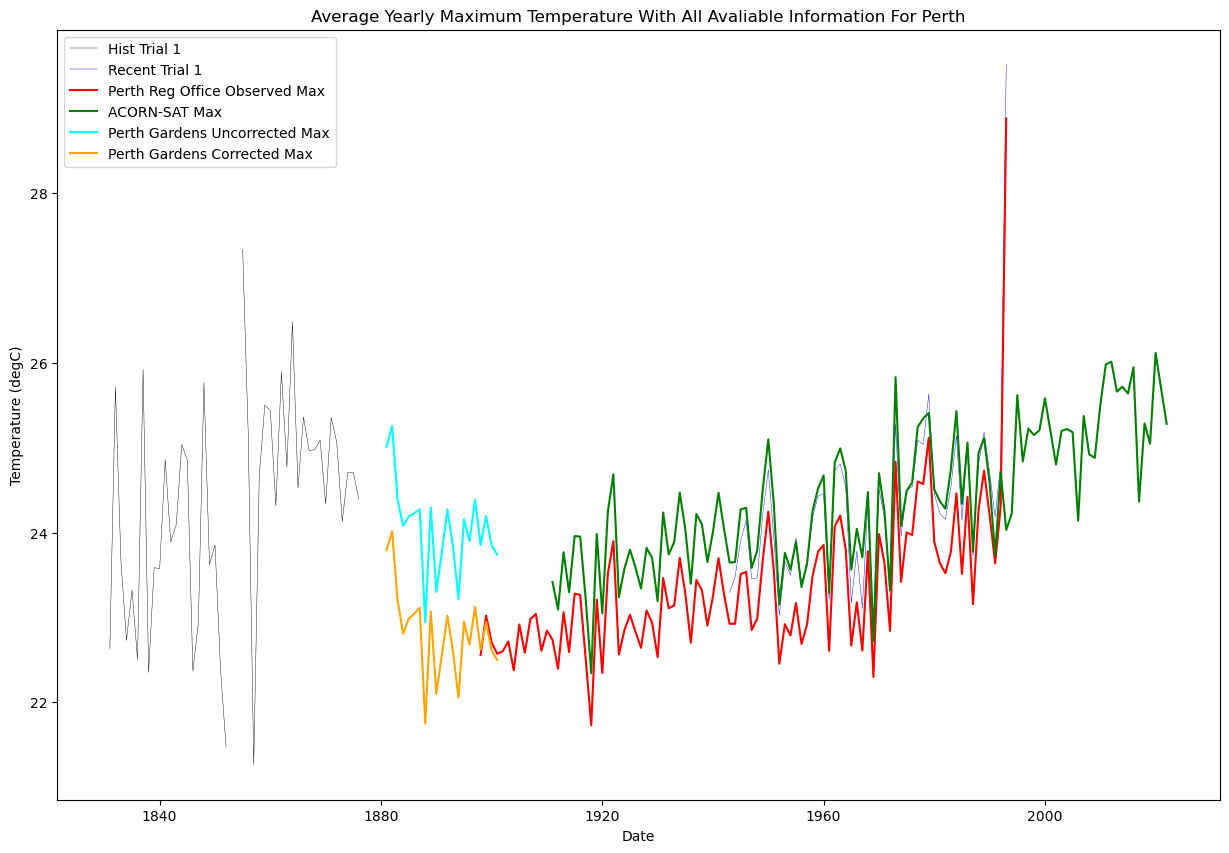

In [219]:
plt.figure(1,figsize= [15,10])
#Historical Estimation
plt.plot(HIST_1['Date'],HIST_1['Max Temp Estimation'],linewidth=0.3,label = 'Hist Trial 1',color = 'black')


#Current Estimation
plt.plot(PRO_1['Date'],PRO_1['Max Temp Estimation'],linewidth=0.3,label = 'Recent Trial 1',color = 'blue')


#PRO DE
plt.plot(PRO_DE_Y['date'],PRO_DE_Y['PRO Max'],linewidth=1.5,label = 'Perth Reg Office Observed Max',color = 'red')

#ACORN_SAT
plt.plot(ACORN_SAT_Y['date'],ACORN_SAT_Y['Max'],linewidth=1.5,label = 'ACORN-SAT Max',color = 'green')

#Perth Gardens
plt.plot(P_Gardens_Y['date'],P_Gardens_Y['tmax'],linewidth=1.5,label = 'Perth Gardens Uncorrected Max',color = 'cyan')

plt.plot(P_Gardens_CORR_Y['date'],P_Gardens_CORR_Y['tmax'],linewidth=1.5, label = 'Perth Gardens Corrected Max',color = 'orange')

plt.legend()

plt.ylabel('Temperature (degC)')
plt.xlabel('Date')
plt.title('Average Yearly Maximum Temperature With All Avaliable Information For Perth')

In [220]:
P = T2.get('Trial_1')
P = P.set_index('Date')

In [221]:
Diff_Max = P['Max Temp Estimation'] -  PRO_DE['PRO Max'].loc['1942-01-01':'1992-04-30'] 
Diff_Min = P['Min Temp Estimation'] -  PRO_DE['PRO Min'].loc['1942-01-01':'1992-04-30'] 


-------------------
[date
1968-01-26 00:00:00    29.6
1968-01-26 03:00:00    32.5
1968-01-26 06:00:00    26.1
1968-01-26 09:00:00    25.1
1968-01-26 12:00:00    27.7
1968-01-26 15:00:00    29.6
1968-01-26 18:00:00    24.9
1968-01-26 21:00:00    23.3
Name: temp, dtype: float64]
-------------------
Max Temp Estimation    45.280521
Min Temp Estimation    18.614816
Correlation Max T       0.823810
Correlation Min T       0.816383
Name: 1968-01-26 00:00:00, dtype: float64
-------------------
[PRO Max    30.2
PRO Min    25.1
Name: 1968-01-26 00:00:00, dtype: float64]


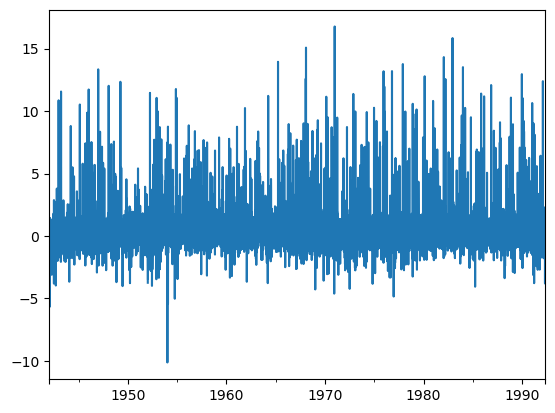

In [239]:
Diff_Max.plot()
Diff_Max[Diff_Max>10]



print('-------------------')
print([PRO_Sub.loc['1968-01-26']])
print('-------------------')
PP =T2.get('Trial_1').set_index('Date')
print(PP.loc['1968-01-26'])
print('-------------------')
print([PRO_DE.loc['1968-01-26']])
#print('-------------------')

In [237]:
T.get('Trial_1').set_index('Date')


,Max Temp Estimation,Min Temp Estimation,Correlation Max T,Correlation Min T
Date,,,,
1830-04-16,26.922819,15.026199,0.961490,0.679252
1830-04-17,27.510722,17.426221,0.961490,0.742353
1830-04-18,29.746799,18.208260,0.763606,0.742353
1830-04-19,28.107215,16.146520,0.901063,0.742353
1830-04-20,26.174652,12.876173,0.953291,0.742353
...,...,...,...,...
1875-12-24,26.774776,16.767684,0.948209,0.775036
1875-12-28,38.875235,22.724676,0.948209,0.775036
1875-12-29,35.979398,21.299071,0.948209,0.775036


<AxesSubplot:>

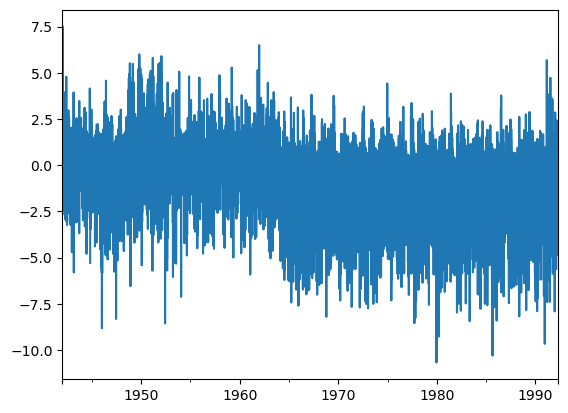

In [223]:
Diff_Min.plot()


In [224]:
#RMSE 
from sklearn.metrics import mean_squared_error
from math import sqrt


In [225]:
#calculate RMSE
actualmx = PRO_DE['PRO Max'].loc['1942-01-01':'1992-04-29']
predmx =  P['Max Temp Estimation'].loc['1942-01-01':'1992-04-29']
Maximum = pd.concat([actualmx,predmx], axis =1).dropna()
RMSEMx = sqrt(mean_squared_error(Maximum['PRO Max'], Maximum['Max Temp Estimation']))


actualmn = PRO_DE['PRO Min'].loc['1942-01-01':'1992-04-29']
predmn =  P['Min Temp Estimation'].loc['1942-01-01':'1992-04-29']
Minimum = pd.concat([actualmn,predmn], axis =1).dropna()
RMSEMn = sqrt(mean_squared_error(Minimum['PRO Min'], Minimum['Min Temp Estimation']))


print(RMSEMx, RMSEMn)

1.3480969685181459 1.3595959498030412


In [ ]:
#calculate RMSE
actualmx = PRO_DE['PRO Max'].loc['1942-01-01':'1992-04-29']
predmx =  P['Max Temp Estimation'].loc['1942-01-01':'1992-04-29']
Maximum = pd.concat([actualmx,predmx], axis =1).dropna()
RMSEMx = sqrt(mean_squared_error(Maximum['PRO Max'], Maximum['Max Temp Estimation']))


actualmn = PRO_DE['PRO Min'].loc['1942-01-01':'1992-04-29']
predmn =  P['Min Temp Estimation'].loc['1942-01-01':'1992-04-29']
Minimum = pd.concat([actualmn,predmn], axis =1).dropna()
RMSEMn = sqrt(mean_squared_error(Minimum['PRO Min'], Minimum['Min Temp Estimation']))


print(RMSEMx, RMSEMn)

A Hours_Avaliable_Inc_24,

B Sub_4_Max, 

C Sub_4_Max_Samp, 

D Sub_4_Min,

E Sub_4_Min_Samp, 

F Max_and_Sub_Dic, 

G Max_and_Sub_Dic_Samp, 

H Min_and_Sub_Dic, 

I Min_and_Sub_Dic_Samp,

J Monthly_Split_Dic, 

K Monthly_Split_Dic_Keys,

L To_Estimate_Closest_Hour

M Sampled_Dictionary

N Keys_Sampled

O Linear_Regressed_Data

P Linear_Regressed_Data_Inner

Q Linear_Regressed_Data_Outer

R Uncut_Estimation_Dic

S key__Uncut_Hist

T Estimated_Historical_Daily_Extremes

U Hist_Proper


In [131]:
T

{'Trial_1':             Date  Max Temp Estimation  Min Temp Estimation  Correlation Max T  \
 0     1830-04-16            25.044977            16.155831           0.962567   
 1     1830-04-17            27.545606            17.374167           0.946389   
 2     1830-04-18            29.351459            18.148525           0.733220   
 3     1830-04-19            28.328174            16.922479           0.908166   
 4     1830-04-20            26.171632            17.690870           0.962567   
 ...          ...                  ...                  ...                ...   
 13800 1875-12-24            26.714812            16.893643           0.957789   
 13801 1875-12-28            39.245534            22.625021           0.957789   
 13802 1875-12-29            36.246729            21.253410           0.957789   
 13803 1875-12-30            33.247924            19.881798           0.957789   
 13804 1875-12-31            27.357413            17.187560           0.957789   
 
   

# 1. The Core Function

In [6]:
def Temperature_Extreme_Estimiation_Function(Training_Subdaily,
                                             Training_Extreme,
                                             Sub_Daily_For_Estimation,
                                            Trials,
                                            Simple):
            
            
                                            #Extreme_Column_Names,
                                             #Trials, Simple):
    '''
    Training_Subdaily:
    Sub-Daily that is used as the training period on the multilinear regression in the form of DataFrame with index
    being DateTime
    
    Training_Extreme:
    Daily Extremes that is used as the training period on the multilinear regression in the form of DataFrame with index
    being DateTime with two columns being the Tmax and Tmin values
    
    Training_Extreme_Max_Min_Col:
    The columns that are used in the Training_Extreme for Tmax and Tmin where Column 0 is Tmax and Column 1 is Tmin
    this must be in the form of strings.
    
    Sub_Daily_For_Estimation:
    The sub_daily data that will be used for estimiting these sub-daily temperatures to the Tmax and Tmin. I the form of DataFrame with index
    being DateTime and a column for its sub-daily temp.
    
    Trials:
    The number of trials that the algorithm will do with the training data.
    '''
    
    #PART 1: Split Training_Subdaily into each individual hour and combine together.
    Sub_4_Max,Sub_4_Max_Samp,Sub_4_Min,Sub_4_Min_Samp,Hours_Avaliable = Sub_Daily_Splitter_To_Matrix(Training_Subdaily)
    
    #PART 2: Concat the Maximum and Minimum Data to the Sub_4_Max, and Sub_4_Min groups
    Max_and_Sub_Dic,Max_and_Sub_Dic_Samp,Min_and_Sub_Dic,Min_and_Sub_Dic_Samp = The_Concat(Hours_Avaliable,Sub_4_Max,Sub_4_Max_Samp,Sub_4_Min,Sub_4_Min_Samp,Training_Extreme)
    
    #Now Every Single Available hour and max and min is ready to be used.
    #Part 3: Split into each respective Month and add all together so its like Month_Hour_Mx/Mn
    Monthly_Split_Dic,Monthly_Split_Dic_Keys = Month_Splitter(Hours_Avaliable, Max_and_Sub_Dic,Max_and_Sub_Dic_Samp,Min_and_Sub_Dic,Min_and_Sub_Dic_Samp)
    
    #Include 24
    Hours_Avaliable_Inc_24 = Hours_Avaliable.copy()
    Hours_Avaliable_Inc_24.append(24)
    
    #PART 4 Is to fix up the Historical Data so it is closest to the every hour hour mark where data is avaliable
    To_Estimate_Closest_Hour = Closest_Hour(Sub_Daily_For_Estimation, Hours_Avaliable_Inc_24)
    
    
    #PART 6
    #Now I need to select 600 points and trail it 1000 times for each single thing in the dictionary and label the hour 0 as hour 0 run 1]
    #and PRO Max Run 1
    Sampled_Dictionary,Keys_Sampled = Sampler_Dictionary(Monthly_Split_Dic,Monthly_Split_Dic_Keys,Trials)
    
    #Part 7
    #Now to apply the regression anaylsis onto the data I have provide
    
    Training_Columns = Training_Extreme.columns
    Linear_Regressed_Data,Linear_Regressed_Data_Inner,Linear_Regressed_Data_Outer = Linear_Regression_Analysis(Hours_Avaliable,Trials,Sampled_Dictionary,Training_Columns)
    
    #Part 8
    #Now estimate each individual Sub-Daily temperature
    Uncut_Estimation_Dic,key_Uncut_Hist = Total_Estimation_Sub_Daily(Trials,To_Estimate_Closest_Hour,Linear_Regressed_Data)
    
    #Part 9
    #Now to choose the best one for the trials when there are 2 or more key temperatures
    Estimated_Historical_Daily_Extremes,Hist_Proper = Final_Estimation_Extreme(Trials,Uncut_Estimation_Dic,Simple)
    
    
    
    return(Hours_Avaliable_Inc_24, Sub_4_Max, Sub_4_Max_Samp, Sub_4_Min, Sub_4_Min_Samp, Max_and_Sub_Dic, Max_and_Sub_Dic_Samp, Min_and_Sub_Dic, Min_and_Sub_Dic_Samp, Monthly_Split_Dic, Monthly_Split_Dic_Keys,To_Estimate_Closest_Hour,Sampled_Dictionary,Keys_Sampled, Linear_Regressed_Data,Linear_Regressed_Data_Inner,Linear_Regressed_Data_Outer, Uncut_Estimation_Dic,key_Uncut_Hist, Estimated_Historical_Daily_Extremes,Hist_Proper)
    

# 2. Sub-Daily Splitter Function

In [7]:
def Sub_Daily_Splitter_To_Matrix(Data):
    '''
    Data:
    A long dataset in the form of DataFrame with index
    being DateTime.
    
    Returns:
    Two dictionaries (Sub_Hourly_Dic_4_Max,Sub_Hourly_Dic_4_Min) and Dataset of their respective keys 
    (Sub_Hourly_Dic_4_Max_Sampled,Sub_Hourly_Dic_4_Min_Sampled) as due to Bureau of Meteorology standards
    for Tmax and Tmin to be required to begin and end at 9am.
    '''
    #Every Hour in 24 hour format
    Every_Hour = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    
    #Dictionary for the hours
    Sub_Hourly_Dic = {}
    Sub_Hourly_Dic_Sampled = []
    Hours_Avaliable = []
    for i in Every_Hour:
        Hour_Key =  "Hour" +"_"+ str(i)
            
        #Hour I: So all data for that hour in a single DataFrame
        Single_Hour_Data = pd.concat([Data[Data.index.hour==i]],axis =0)
        #If the data has more then 10 years of data keep it
        if (len(Single_Hour_Data) >= 3600):
            #Make sure that the date is reset to fix it up
            Single_Hour_Data = Single_Hour_Data.reset_index()
            #Make sure that datetime is still on the date we used
            Single_Hour_Data['date'] = pd.to_datetime(Single_Hour_Data['date']).dt.date
            #Set Index back to date, but maybe not if we need to make it for Max and Min
            Single_Hour_Data = Single_Hour_Data.set_index('date').dropna()
            #Add to Dictionaries and columns
            Sub_Hourly_Dic[Hour_Key] = Single_Hour_Data
            Sub_Hourly_Dic_Sampled.append(Hour_Key)
            Hours_Avaliable.append(i)
            
    
    
    #Now to place it into Max and Min format
    #Min is from 9-1,10-1,11-1,12-1...23-1,0+0,1+0...8+0
    #Max is from 9+0,10+0,11+0,12+0...23+0,0+1,1+1...8+1
    Sub_Hourly_Dic_4_Max = {}
    Sub_Hourly_Dic_4_Max_Sampled = []
    Sub_Hourly_Dic_4_Min = {}
    Sub_Hourly_Dic_4_Min_Sampled = []
    
    for i in Hours_Avaliable:
        Into_Max_Or_Min = Sub_Hourly_Dic.get('Hour_{}'.format(i))
        #We start with Max
        if (i in range(0, 9)):
            Key_Hour_Max =  "Hour" +"_"+ str(i)+"+1"
            #Shift Into_Max_Or_Min Up 1
            Max_Shift = Into_Max_Or_Min.shift(-1, axis = 0).dropna()
            Sub_Hourly_Dic_4_Max[Key_Hour_Max] = Max_Shift
        else:
            Key_Hour_Max =  "Hour" +"_"+ str(i)+"+0"
            #Shift Into_Max_Or_Min Up 1
            Max_Shift = Into_Max_Or_Min
            Sub_Hourly_Dic_4_Max[Key_Hour_Max] = Max_Shift
        Sub_Hourly_Dic_4_Max_Sampled.append(Key_Hour_Max)
        
        
        #Now We Go with Min
        if (i in range(9, 24)):
            Key_Hour_Min =  "Hour" +"_"+ str(i)+"-1"
            #Shift Into_Max_Or_Min Down 1
            Min_Shift = Into_Max_Or_Min.shift(1, axis = 0).dropna()
            Sub_Hourly_Dic_4_Min[Key_Hour_Min] = Min_Shift
        else:
            Key_Hour_Min =  "Hour" +"_"+ str(i)+"+0"
            #Shift Into_Max_Or_Min Up 1
            Min_Shift = Into_Max_Or_Min
            Sub_Hourly_Dic_4_Min[Key_Hour_Min] = Min_Shift
        Sub_Hourly_Dic_4_Min_Sampled.append(Key_Hour_Min)
    
    return(Sub_Hourly_Dic_4_Max, Sub_Hourly_Dic_4_Max_Sampled,Sub_Hourly_Dic_4_Min,Sub_Hourly_Dic_4_Min_Sampled,Hours_Avaliable)
    


# 3. Concat Tmax and Tmin to 

In [8]:
def The_Concat(Hours_Avaliable,Sub_4_Max,Sub_4_Max_Samp,Sub_4_Min,Sub_4_Min_Samp,Training_Extreme):
    '''
    Sub_4_Max and Sub_4_Min:
    The dictionaries created from Sub_Daily_Splitter_To_Matrix.
    
    Sub_4_Max_Samp and Sub_4_Min_Samp:
    The keys to the dictionaries from Sub_Daily_Splitter_To_Matrix.
    
    Training_Extreme:
    Daily extremes to be appended onto the Sub_4_...
    
    Training_Extreme_Max_Min_Col:
    The names of the columns of the Training_Extreme

    Returns:
    Two dictionaries (Max_and_Sub_Dic, Min_and_Sub_Dic) and Dataset of their respective keys 
    (Max_and_Sub_Dic_Samp, Min_and_Sub_Dic_Samp) as due to Bureau of Meteorology standards
    for Tmax and Tmin to be required to begin and end at 9am with the max and min temperaturew included.
    
    '''
    #Create dictionary and empy datasets
    Max_and_Sub_Dic = {}
    Max_and_Sub_Dic_Samp = []
    Min_and_Sub_Dic = {}
    Min_and_Sub_Dic_Samp = []
    #Start with Tmax
    for i in range(len(Sub_4_Max_Samp)):
        #Make the key
        Key_Hour_Max =  "Hour" +"_"+ str(Hours_Avaliable[i])
        #Extract the Sub_4_Max Dataset
        Sub_4_Max_Conc = Sub_4_Max.get(Sub_4_Max_Samp[i])
        #Combine Tmax
        Combined_Recent_Info = pd.merge(left = Sub_4_Max_Conc, 
                                        right  =Training_Extreme[Training_Extreme.columns[0]],
                                        left_index=True,right_index=True  )
        Max_and_Sub_Dic[Key_Hour_Max] = Combined_Recent_Info
        Max_and_Sub_Dic_Samp.append(Key_Hour_Max)
        
        
    #Go with Tmin
    for i in range(len(Sub_4_Max_Samp)):
        #Make the key
        Key_Hour_Min =  "Hour" +"_"+ str(Hours_Avaliable[i])
        #Extract the Sub_4_Max Dataset
        Sub_4_Min_Conc = Sub_4_Min.get(Sub_4_Min_Samp[i])
        #Combine Tmax
        Combined_Recent_Info = pd.merge(left = Sub_4_Min_Conc,
                                        right  =Training_Extreme[Training_Extreme.columns[1]],
                                        left_index=True,right_index=True)
        Min_and_Sub_Dic[Key_Hour_Min] = Combined_Recent_Info
        
        Min_and_Sub_Dic_Samp.append(Key_Hour_Min)
        
    return(Max_and_Sub_Dic,Max_and_Sub_Dic_Samp,Min_and_Sub_Dic,Min_and_Sub_Dic_Samp )

# 4. Max and Min with Sub-Daily Month Splitter

In [9]:
# Function that splits it into each month
def Month_Splitter(Hours_Avaliable, Max_and_Sub_Dic,Max_and_Sub_Dic_Samp,Min_and_Sub_Dic,Min_and_Sub_Dic_Samp):
    '''
    Hours_Avaliable:
    Hours used in the sub_daily that are avalible to us
    
    Max_and_Sub_Dic and Min_and_Sub_Dic:
    The dictionaries created from Sub_Daily_Splitter_To_Matrix.
    
    Max_and_Sub_Dic_Samp and Max_and_Sub_Dic_Samp:
    The keys to the dictionaries from Sub_Daily_Splitter_To_Matrix.
    
    Sub_4_Max and Sub_4_Min:
    The dictionaries created from Sub_Daily_Splitter_To_Matrix.
    
    Sub_4_Max_Samp and Sub_4_Min_Samp:
    The keys to the dictionaries from Sub_Daily_Splitter_To_Matrix.
    
    
    
    '''
    Month_Number = [1,2,3,4,5,6,7,8,9,10,11,12]
    Month_Name = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    Monthly_Split_Dic = {}
    Monthly_Split_Dic_Keys =[]
    #Begin a for loop
    for i in Hours_Avaliable:
        #Extract Max and Min
        Max_Data = Max_and_Sub_Dic.get('Hour_{}'.format(i))
        Min_Data = Min_and_Sub_Dic.get('Hour_{}'.format(i))
        
        #Extract the Month Number
        for q in range(len(Month_Number)):
            Month_Max_Data = pd.concat([Max_Data[Max_Data.index.month==Month_Number[q]],], axis = 0)
            Month_Min_Data = pd.concat([Min_Data[Min_Data.index.month==Month_Number[q]],], axis = 0)
            #Add to Dictionary
            Key_Max = Month_Name[q] +"_"+ str(i) + "_"+"Mx"
            Key_Min = Month_Name[q] +"_"+ str(i) +"_"+ "Mn"
            Monthly_Split_Dic[Key_Max] = Month_Max_Data
            Monthly_Split_Dic[Key_Min] = Month_Min_Data
            Monthly_Split_Dic_Keys.append(Key_Max)
            Monthly_Split_Dic_Keys.append(Key_Min)


    return(Monthly_Split_Dic,Monthly_Split_Dic_Keys)



# 5. Closest Hour Function

In [10]:
def Closest_Hour(Data, hours): #COMPLETED
    '''
    Data:
    The sub_daily data we are aiming to estimate the Tmax and Tmin from
    
    hours:
    The hours that are avaliable to use
    
    Returns:
    Dataset that has the closest hour to one of the avalaible hours in the dataset.
        
    '''
    closest_hour= []
    
    #We want to match to the hour closest to the 3

    for i in range(len(Data)):
        #Extract the single day
        Individual_Day = Data.loc[i]
    
        #Extract hour
        Individual_Hour = Individual_Day['date'].hour
        
        #Take the closest hour
        Closest_Ind_Hour = take_closest(hours, Individual_Hour)
        
        #If closest hour is 24, make sure it takes the closest hour on either side with the 23 and lower being favoured
        if (Closest_Ind_Hour == 24):
            Left_Check= abs(24 - hours[len(hours)-2])
            Right_Check = abs(hours[0]-0)
            
            
            if Left_Check > Right_Check:
                Closest_Ind_Hour = hours[0]
            else:
                Closest_Ind_Hour = hours[len(hours)-2]
            
        
        #Append the closest hour 
        closest_hour.append(Closest_Ind_Hour)
    
    #Add it as a series then combine to make it a dataframe
    CL = pd.Series(closest_hour, name = 'Closest Hour')
    Dataset = pd.merge(left = Data,right  =CL,left_index=True,right_index=True  )
    return(Dataset)

## 5.1 The Inner of the Closest Hour Function

In [11]:
def take_closest(myList, myNumber): 
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    
    myList: 
        The values that the data can be closest to
    
    myNumber:
        The raw value that will then be converted to the Closest Hour
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

# 6. Sampling To Dictionary

In [12]:
def Sampler_Dictionary(Data,Key,Trials):
    

    #Now I need to select random samples from the length of the data we found for each month 
    #points and trail it 1000 times for each single thing in the dictionary and label the hour 0 as hour 0 run 1
    #and PRO Max Run 1


    #Get useful data ready
    Sampled_Dictionary = {}  
    Keys_Sampled = []


    #Firstly extract that part of the dictionary to be used
    for keys_used in Key:
        #Extract  and drop any nans
        Dataset = Data.get(keys_used).dropna()
    
        #The sampling
        #So we get a new dataset so it doesnt replace the original values
        #Do a single run so it appends to the RUNS and this is the samples which is the same length as the dataset used
        Run1_Data = Dataset.sample(n=int(len(Dataset)),replace=True)
        #Drop the date column
        Run1_Data = Run1_Data.reset_index(drop = True)
        #Index is 0 to 9, or 0 to Samples-1
        #Get the columns names
        Col = Run1_Data.columns
    
        #Now change column name to make it run 1 etc
        Run1_Data= Run1_Data.rename(columns={Col[0]:Col[0] + ' ' +  'run 1'})
        Run_Data= Run1_Data.rename(columns={Col[1]:Col[1] + ' ' +  'run 1'})
    

        #Now develope the for loop but the trials is based off the lenght of Data
        for rns in range(2,Trials+1):
            #This is the now the random sampling for 1000 different samples of 600 
            Individual_Run = Dataset.sample(n=int(len(Dataset)),replace=True)
            #Drop the date column
            Individual_Run = Individual_Run.reset_index(drop = True)
            #Index is 0 to 9, or 0 to Samples-1
            #Get the columns names
            Col = Individual_Run.columns
        
            #Now change column name to make it run 1 etc
            Individual_Run= Individual_Run.rename(columns={Col[0]:Col[0] + ' ' +  'run {}'.format(rns)})
            Individual_Run= Individual_Run.rename(columns={Col[1]:Col[1] + ' ' +  'run {}'.format(rns)})
        
            #Concate with RUNS
            Run_Data = pd.concat([Run_Data, Individual_Run],axis=1)
        #Now create a new dictionary that uses the name of the old dictorinary + sampling to put these runs into
    
    
    

        key = keys_used + "_" + "Sampled"
    
        #Add it in the dictionary
        Sampled_Dictionary[key] = Run_Data
    
        Keys_Sampled.append(key)
        
    return(Sampled_Dictionary,Keys_Sampled)

# 7. Linear Regression

In [13]:
def Linear_Regression_Analysis(hours,Trials,Data, Training_Columns):


    #Get useful data ready
    Reg_Trial_Data = {}
    All_data = {}
    Key_Outer = []
    Key_Inner = []
    Month_Name = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


    for month_num in range(0,12):
        #Extract the month name
        Month_Str =  Month_Name[month_num]  
    
        
        for trial_number in range(1,Trials+1):
            #Go by trail first
            AMx_Total = []
            BMx_Total = []
            CORRMx_Total = []
            Time = []
            AMn_Total = []
            BMn_Total = []
            CORRMn_Total = []
            for i in hours:
                #---MAX---#
                #Extract the maximum data
                Mxt = Data.get('{}_{}_Mx_Sampled'.format(Month_Str,i))
                #Get the linear formula and the correlation of the data
                AMx, BMx, corrMx = linear_regression_polyfit(Mxt['temp run {}'.format(trial_number)],Mxt['{} run {}'.format(Training_Columns[0],trial_number)])
                #Append it all
                AMx_Total.append(AMx)
                BMx_Total.append(BMx)
                CORRMx_Total.append(corrMx)
                #Repeat for min
                #---MIN---#
                Mnt = Data.get('{}_{}_Mn_Sampled'.format(Month_Str,i))
                AMn, BMn, corrMn = linear_regression_polyfit(Mnt['temp run {}'.format(trial_number)],Mnt['{} run {}'.format(Training_Columns[1], trial_number)])
                Time.append(int(i)) 
                AMn_Total.append(AMn)
                BMn_Total.append(BMn)
                CORRMn_Total.append(corrMn)
                
            #Add it all into a dataframe
            Time = pd.Series(Time,name = 'Hours')
            
            AMX = pd.Series(AMx_Total,name = 'A')
            BMX = pd.Series(BMx_Total,name = 'B')
            corrMX = pd.Series(CORRMx_Total,name = 'CORR')
            ItemsMX = pd.concat([Time,AMX,BMX,corrMX],axis = 1)
            
            AMN = pd.Series(AMn_Total,name = 'A')
            BMN = pd.Series(BMn_Total,name = 'B')
            corrMN = pd.Series(CORRMn_Total,name = 'CORR')
            ItemsMN = pd.concat([Time,AMN,BMN,corrMN],axis = 1)
            
            key1 =  "{}".format(Month_Str) + "_" + 'Trial'+ "_" + str(trial_number) + "_" + "Mx"
            Reg_Trial_Data[key1] = ItemsMX
            Key_Inner.append(key1)
            
            key2 =  "{}".format(Month_Str) + "_" + 'Trial'+ "_" + str(trial_number) + "_" + "Mn"
            Reg_Trial_Data[key2] = ItemsMN
            Key_Inner.append(key2)
            
        key3 =  "{}".format(Month_Str) 
        All_data[key3] = Reg_Trial_Data
        Key_Outer.append(key3)
            
         
        
        
    return(All_data,Key_Inner,Key_Outer)

## 7.1 The fitting function for the linear polyfit

In [14]:
#Now develop the linear regression equation
def linear_regression_polyfit(x,y):
    #Find the linear Relationship
    A, B = np.polyfit(x, y, 1)
    #Find the correlation                  
    corr, _ = pearsonr(x, y)
    return(A,B,corr)

# 8. Estimating Tmax and Tmin Function

In [15]:
def Total_Estimation_Sub_Daily(Trials,Historical_Dataset,Linear_Regressed_Data):
    #The final stage is to build the estimation checker etc
    #What we have is
    Uncut_Estimation_Dic = {}
    
    for trialing in range(1,Trials+1):
        #All the saved information
        Estimated_Max = []
        Estimated_Min = []
        Max_T_Correlation = []
        Min_T_Correlation = []

        
        #Now lets go into the index of each individual vlaue
        for indexed in range(len(Historical_Dataset)):
            #Extract the particular day of focus
            Hist_Day = Historical_Dataset.loc[indexed]
            
            #Extract hour, month and temp
            Month_Extractor = Hist_Day['date'].month
            Hour = Hist_Day['Closest Hour']
            Temp = Hist_Day['temp']
            #Estimation funcion
            Est_Max, Est_Min, Correlation_Max, Correlation_Min = estimation_ind_day_function(Month_Extractor, Hour,
                                                                                         Temp, Linear_Regressed_Data, 
                                                                                         trialing)
            Estimated_Max.append(Est_Max)
            Estimated_Min.append(Est_Min)
            Max_T_Correlation.append(Correlation_Max)
            Min_T_Correlation.append(Correlation_Min)
        
           
        #Add to the historical period
        Estimated_Max = pd.Series(Estimated_Max,name = 'Max Temp Estimation')
        Estimated_Min = pd.Series(Estimated_Min,name = 'Min Temp Estimation')
        Max_T_Correlation = pd.Series(Max_T_Correlation,name = 'Correlation Max T')
        Min_T_Correlation = pd.Series(Min_T_Correlation,name = 'Correlation Min T')
        Dataset = pd.concat([Historical_Dataset, Estimated_Max,Estimated_Min,Max_T_Correlation,Min_T_Correlation],axis=1)

        #Add to a dictionary
    
        key_Hist = 'Trial'+ "_" + str(trialing)
        Uncut_Estimation_Dic[key_Hist] = Dataset
    return(Uncut_Estimation_Dic,key_Hist)

## 8.1 Estimating the Individual Day

In [16]:
def estimation_ind_day_function(MONTH, Hour, Temp, DATA_4_EST, Trial_Number):
    if (MONTH == 1):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
            
        #Estimate Max
        Information_Max = DATA_4_EST.get('Jan').get('Jan_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Jan').get('Jan_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
        
        
    elif (MONTH == 2):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
    
    
        #Estimate Max
        Information_Max = DATA_4_EST.get('Feb').get('Feb_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Feb').get('Feb_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
        
    
    elif (MONTH == 3):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
    
        #Estimate Max
        Information_Max = DATA_4_EST.get('Mar').get('Mar_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Mar').get('Mar_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
        
    elif (MONTH == 4):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
    
        #Estimate Max
        
        Information_Max = DATA_4_EST.get('Apr').get('Apr_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Apr').get('Apr_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
        
    elif (MONTH == 5):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
    
        #Estimate Max
        Information_Max = DATA_4_EST.get('May').get('May_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('May').get('May_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
        
    elif (MONTH == 6):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
        #Estimate Max
        Information_Max = DATA_4_EST.get('Jun').get('Jun_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Jun').get('Jun_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
        
    elif (MONTH == 7):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
        #Estimate Max
        Information_Max = DATA_4_EST.get('Jul').get('Jul_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Jul').get('Jul_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
        
        
    elif (MONTH == 8):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
        #Estimate Max
        Information_Max = DATA_4_EST.get('Aug').get('Aug_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Aug').get('Aug_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
    
    elif (MONTH == 9):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
        #Estimate Max
        Information_Max = DATA_4_EST.get('Sep').get('Sep_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Sep').get('Sep_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
        
        
    elif (MONTH == 10):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
        #Estimate Max
        Information_Max = DATA_4_EST.get('Oct').get('Oct_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Oct').get('Oct_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
    
    elif (MONTH == 11):
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
        #Estimate Max
        Information_Max = DATA_4_EST.get('Nov').get('Nov_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Nov').get('Nov_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
    
    else:
        #Find Index Closest to Hour
        Index_Found = np.divide(Hour,3)
        if (Index_Found == 8):
            Index_Found = 0
        else:
            Index_Found = Index_Found
            
            
        #Estimate Max
        Information_Max = DATA_4_EST.get('Dec').get('Dec_Trial_{}_Mx'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Max = Information_Max['A']*Temp + (Information_Max['B'])
        Correlation_Max =  Information_Max['CORR']
    
        #Estimate Min
        Information_Min = DATA_4_EST.get('Dec').get('Dec_Trial_{}_Mn'.format(Trial_Number)).loc[int(Index_Found)]
        Est_Min = Information_Min['A']*Temp + (Information_Min['B'])
        Correlation_Min =  Information_Min['CORR']
        
    return(Est_Max,Est_Min,Correlation_Max,Correlation_Min)

# 9. The Historical Tmax and Tmin Estimation

In [17]:
def Final_Estimation_Extreme(Trials,Data,Simple):
    #Create_Dictionary
    Estimated_Historical_Daily_Extremes = {}
    key_hist =  []
    #Start by going into individual trials
    for ind_trial in range(1,Trials+1):
        #Extract the dictionary that is for the trial
        Sing_Hist_Est = Data.get('Trial_{}'.format(ind_trial))
        #go through each day and get th best one for that day
        # Remove the duplicates out of the day it will make it easier for the for loop trust.
        #Get the individual columns for the dates
        Sing_Hist_Est['Day'] = Sing_Hist_Est['date'].dt.day
        Sing_Hist_Est['Month'] = Sing_Hist_Est['date'].dt.month
        Sing_Hist_Est['Year'] = Sing_Hist_Est['date'].dt.year
        Estimation_Date = Sing_Hist_Est[['date','Year','Month','Day']]
        #Combine together as it removes hourly out of the datetime
        Estimation_Date['Undup Dates']=pd.to_datetime(Estimation_Date[['Year','Month','Day']])
        #Delete all other column remove dups reset index for looping, keep the undup dates and sub cats as well.
        Estimation_Date = Estimation_Date.drop_duplicates(subset=['Undup Dates'])
        del Estimation_Date['date']
        Estimation_Date = Estimation_Date.reset_index(drop = True)
        
        #The dataclean up is ready nn
        Sing_Hist_Est = Sing_Hist_Est.set_index('date')
        #Now we have to go through each individual day, check whether there is two or more values. So this is the first check
        Max_Estimated = []
        Max_CORR_Estimated = []
        Min_Estimated = []
        Min_CORR_Estimated = []
        Dates = []
        for i in range(len(Estimation_Date)):
            #Get the individual date
            located_date = Sing_Hist_Est.loc['{}-{}-{}'.format(Estimation_Date['Year'][i],Estimation_Date['Month'][i],Estimation_Date['Day'][i])]
            located_date = located_date.reset_index()
            
            
            #From here
            if (Simple == True):
                Estimated_Max,Estimated_Min,Correlation_Max,Correlation_Min =  estimation_single_date_temp_Simple(located_date)
            else:
                Estimated_Max,Estimated_Min,Correlation_Max,Correlation_Min =  estimation_single_date_temp_Complex(located_date)
            Max_Estimated.append(Estimated_Max)
            Max_CORR_Estimated.append(Correlation_Max)
            Min_Estimated.append(Estimated_Min)
            Min_CORR_Estimated.append(Correlation_Min)
         
        Max_Estimated = pd.Series(Max_Estimated,name = 'Max Temp Estimation')
        Min_Estimated = pd.Series(Min_Estimated,name = 'Min Temp Estimation')
        Max_CORR_Estimated = pd.Series(Max_CORR_Estimated,name = 'Correlation Max T')
        Min_CORR_Estimated = pd.Series(Min_CORR_Estimated,name = 'Correlation Min T')
        Estimated_Temp = pd.concat([Estimation_Date['Undup Dates'], Max_Estimated,Min_Estimated,Max_CORR_Estimated,Min_CORR_Estimated],axis=1)
        Estimated_Temp = Estimated_Temp.rename(columns={'Undup Dates':'Date'})
        #Add to a dictionary
    
        key_Hist_Proper = 'Trial'+ "_" + str(ind_trial)
        Estimated_Historical_Daily_Extremes[key_Hist_Proper] = Estimated_Temp
        key_hist.append(key_Hist_Proper)
    return(Estimated_Historical_Daily_Extremes,key_hist)

## 9.1 Individual Day Estimation Complex

In [18]:
def estimation_single_date_temp_Complex(data):
    #print('Start')  #ASSESS ONCE MORE, I NEED TO MAKE SURE IT WORKS
    
    
    '''----- MAX -----'''
    
    
    if (len(data) == 1): #Single Case: Most simple
        #This finds the values required for a length of 1 data
        Estimated_Max = data['Max Temp Estimation'].loc[0]
        Correlation_Max = data['Correlation Max T'].loc[0]
        #print(1)
        
    elif (len(data) == 2): #Case where there ARE only two estimates
        #Lets extract the row with the highes correlation
        Highest_Correlation_Max = data.loc[data['Correlation Max T'] == data['Correlation Max T'].max()]
        #Reset index so it becomes useful later
        Highest_Correlation_Max = Highest_Correlation_Max.reset_index(drop = True)
        
        #Extract the highest observed temperatures
        Highest_Observed_Temperature = data.loc[data['temp'] == data['temp'].max()]
        Highest_Observed_Temperature = Highest_Observed_Temperature.reset_index(drop = True)
        
        #print(2)
        
            
        #Is the estimated temperature from the highest correlated temp greater or equal to the higher observed 
        if (Highest_Correlation_Max['Max Temp Estimation'].loc[0] >= Highest_Observed_Temperature['temp'].loc[0]):
            #This takes the highest correlation max temp estimation
            Estimated_Max = Highest_Correlation_Max['Max Temp Estimation'].loc[0]
            Correlation_Max = Highest_Correlation_Max['Correlation Max T'].loc[0]
            #print(3)
        else:
            #This takes the highest observed temp max temp estimation
            Estimated_Max = Highest_Observed_Temperature['Max Temp Estimation'].loc[0]
            Correlation_Max = Highest_Observed_Temperature['Correlation Max T'].loc[0]
            #print(4)
        
    
    else: #Now for 3 or more subdaily times
        #Similar to the steps in the elif part, the start of this part mimics that
        #Lets extract the row with the highes correlation
        Highest_Correlation_Max = data.loc[data['Correlation Max T'] == data['Correlation Max T'].max()]
        #Reset index so it becomes useful later
        Highest_Correlation_Max = Highest_Correlation_Max.reset_index(drop = True)
        
        #Extract the highest observed temperatures
        Highest_Observed_Temperature = data.loc[data['temp'] == data['temp'].max()]
        Highest_Observed_Temperature = Highest_Observed_Temperature.reset_index(drop = True)
        
        #print(5)
        
            
        #Is the estimated temperature from the highest correlated temp greater or equal to the higher observed 
        if (Highest_Correlation_Max['Max Temp Estimation'].loc[0] >= Highest_Observed_Temperature['temp'].loc[0]):
            #This takes the highest correlation max temp estimation
            Estimated_Max = Highest_Correlation_Max['Max Temp Estimation'].loc[0]
            Correlation_Max = Highest_Correlation_Max['Correlation Max T'].loc[0]
            #print(6)
        else:
            #The deviation to the elif part of the ifelse statement begins here
            #Extract the largest Estimation Max
            Highest_Estimation_Max = data.loc[data['Max Temp Estimation'] == data['Max Temp Estimation'].max()]
            Highest_Estimation_Max = Highest_Estimation_Max.reset_index(drop = True)
            #print(7)
            #Now choose to see what is the highest correlation value out of these two
            if (Highest_Observed_Temperature['Correlation Max T'].loc[0] >= Highest_Estimation_Max['Correlation Max T'].loc[0]):
                Estimated_Max = Highest_Observed_Temperature['Max Temp Estimation'].loc[0]
                Correlation_Max = Highest_Observed_Temperature['Correlation Max T'].loc[0]
                #print(8)
            else:
                #This is if the other highest estimation temperature that is not the highest correlated is used
                Estimated_Max = Highest_Estimation_Max['Max Temp Estimation'].loc[0]
                Correlation_Max = Highest_Estimation_Max['Correlation Max T'].loc[0]
                #print(9)

    '''----- MIN -----'''
    
    
    if (len(data) == 1): #Single Case: Most simple
        #This finds the values required for a length of 1 data
        Estimated_Min  = data['Min Temp Estimation'].loc[0]
        Correlation_Min = data['Correlation Min T'].loc[0]
        
    elif (len(data) == 2): #Case where there ARE only two estimates
        #Lets extract the row with the highes correlation
        Highest_Correlation_Min = data.loc[data['Correlation Min T'] == data['Correlation Min T'].max()]
        #Reset index so it becomes useful later
        Highest_Correlation_Min = Highest_Correlation_Min.reset_index(drop = True)
        
        #Extract the lowest observed temperatures
        Lowest_Observed_Temperature = data.loc[data['temp'] == data['temp'].min()]
        Lowest_Observed_Temperature = Lowest_Observed_Temperature.reset_index(drop = True)
             
            
        #Is the estimated temperature from the highest correlated temp lower or equal to the lower observed temp
        if (Highest_Correlation_Min['Min Temp Estimation'].loc[0] <= Lowest_Observed_Temperature['temp'].loc[0]):
            #This takes the highest correlation min temp estimation
            Estimated_Min = Highest_Correlation_Min['Min Temp Estimation'].loc[0]
            Correlation_Min = Highest_Correlation_Min['Correlation Min T'].loc[0]
        
        else:
            #This takes the lowest observed temp max temp estimation
            Estimated_Min = Lowest_Observed_Temperature['Min Temp Estimation'].loc[0]
            Correlation_Min = Lowest_Observed_Temperature['Correlation Min T'].loc[0]
        
    
    else: #Now for 3 or more subdaily times
        #Similar to the steps in the elif part, the start of this part mimics that
        #Lets extract the row with the highes correlation
        Highest_Correlation_Min = data.loc[data['Correlation Min T'] == data['Correlation Min T'].max()]
        #Reset index so it becomes useful later
        Highest_Correlation_Min = Highest_Correlation_Min.reset_index(drop = True)
        
        #Extract the lowest observed temperatures
        Lowest_Observed_Temperature = data.loc[data['temp'] == data['temp'].min()]
        Lowest_Observed_Temperature = Lowest_Observed_Temperature.reset_index(drop = True)
             
            
        #Is the estimated temperature from the highest correlated temp lower or equal to the lower observed temp
        if (Highest_Correlation_Min['Min Temp Estimation'].loc[0] <= Lowest_Observed_Temperature['temp'].loc[0]):
            #This takes the highest correlation min temp estimation
            Estimated_Min = Highest_Correlation_Min['Min Temp Estimation'].loc[0]
            Correlation_Min = Highest_Correlation_Min['Correlation Min T'].loc[0]
            
            
            
        else:
            #The deviation to the elif part of the ifelse statement begins here
            #Extract the lowest Estimation MIN
            Lowest_Estimation_Min = data.loc[data['Min Temp Estimation'] == data['Min Temp Estimation'].min()]
            Lowest_Estimation_Min = Lowest_Estimation_Min.reset_index(drop = True)
            #Now choose to see what is the highest correlation value out of these two
            if (Lowest_Observed_Temperature['Correlation Min T'].loc[0] >= Lowest_Estimation_Min['Correlation Min T'].loc[0]):
                Estimated_Min = Lowest_Observed_Temperature['Min Temp Estimation'].loc[0]
                Correlation_Min = Lowest_Observed_Temperature['Correlation Min T'].loc[0]
            else:
                #This is if the other highest estimation temperature that is not the highest correlated is used
                Estimated_Min = Lowest_Estimation_Min['Min Temp Estimation'].loc[0]
                Correlation_Min = Lowest_Estimation_Min['Correlation Min T'].loc[0]

    
    
    #print('End')
    return(Estimated_Max,Estimated_Min,Correlation_Max,Correlation_Min)

## 9.2 Individual Day Estimation Simple

In [19]:
def estimation_single_date_temp_Simple(data):
  
    #Single Case: Most simple
    if (len(data) == 1):
        #This finds the values required for a length of 1 data
        Estimated_Max = data['Max Temp Estimation'].loc[0]
        Estimated_Min = data['Min Temp Estimation'].loc[0]
        Correlation_Max = data['Correlation Max T'].loc[0]
        Correlation_Min = data['Correlation Min T'].loc[0]


    else:
        #--------- MAX ------------#
        #Doing something more complicated
        #First lets find the max of the correlation for the max and min
    
        #nOW FOR TWO INDICES
        #First we choose the highest correlation as the initial condition
        Mx_o_Mx_Corr = data.loc[data['Correlation Max T'] == data['Correlation Max T'].max()]
        Mx_o_Mx_Corr = Mx_o_Mx_Corr.reset_index(drop = True)
        Estimated_Max = Mx_o_Mx_Corr['Max Temp Estimation'].loc[0]
        Correlation_Max = Mx_o_Mx_Corr['Correlation Max T'].loc[0]
    
    
         #--------- MIN ------------#
        #Doing something more complicated
        #First lets find the max of the correlation for the max and min
    
        #nOW FOR TWO INDICES
        #First we choose the highest correlation as the initial condition
        Mx_o_Mn_Corr = data.loc[data['Correlation Min T'] == data['Correlation Min T'].max()]
        Mx_o_Mn_Corr = Mx_o_Mn_Corr.reset_index(drop = True)
    
   
        Estimated_Min = Mx_o_Mn_Corr['Min Temp Estimation'].loc[0]
        Correlation_Min = Mx_o_Mn_Corr['Correlation Min T'].loc[0]
        
        
    return(Estimated_Max,Estimated_Min,Correlation_Max,Correlation_Min)

O Linear_Regressed_Data

P Linear_Regressed_Data_Inner

Q Linear_Regressed_Data_Outer

In [25]:
O2

{'Jan': {'Jan_Trial_1_Mx':    Hours         A         B      CORR
  0      0  1.375756 -0.103774  0.878944
  1      3  1.283799  3.929482  0.837805
  2      6  1.259002  5.937412  0.782828
  3      9  1.142341  3.226020  0.811222
  4     12  1.086206 -0.065689  0.956471
  5     15  1.029921  1.144592  0.954219
  6     18  1.050886  2.544500  0.903024
  7     21  1.239391  0.864116  0.881771,
  'Jan_Trial_1_Mn':    Hours         A         B      CORR
  0      0  0.820584  0.777745  0.893067
  1      3  0.876349  0.931198  0.958679
  2      6  0.946991  0.595037  0.982960
  3      9  0.649902  3.485132  0.744087
  4     12  0.529616  4.128237  0.806205
  5     15  0.519341  4.182516  0.818757
  6     18  0.596136  3.146862  0.824435
  7     21  0.700559  2.369065  0.824731,
  'Feb_Trial_1_Mx':    Hours         A         B      CORR
  0      0  1.190656  3.954316  0.809936
  1      3  1.154989  6.359732  0.782604
  2      6  1.094014  9.221656  0.740369
  3      9  1.064584  5.555477  0.7